In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


C:\Users\chees\AppData\Local\Temp\ipykernel_2320\2471238734.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.rand(1)
C:\Users\chees\AppData\Local\Temp\ipykernel_2320\2471238734.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
C:\Users\chees\AppData\Local\Temp\ipykernel_2320\2471238734.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*n

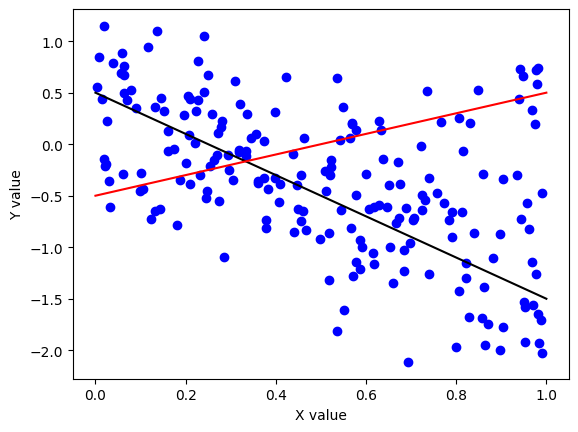

(200,)


In [6]:
#Generating the data given the code in the assignment

np.random.seed(0)
n = 200 #sample size
K = 2 #number of lines
e = np.array([0.7,0.3]) #mixing weights
w = np.array([-2,1]) #slopes of lines
b = np.array([0.5,-0.5]) #offsets of lines
v = np.array([0.2,0.1]) #variances
x = np.zeros([n])
y = np.zeros([n])
for i in range(0,n):
    x[i] = np.random.rand(1)
    if np.random.rand(1) < e[0]:
        y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*np.sqrt(v[0])
    else:
        y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
plt.plot(x,y,'bo')
t = np.linspace(0, 1, num=100)
plt.plot(t,w[0]*t+b[0],'k',color='black')
plt.plot(t,w[1]*t+b[1],'k',color='red')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.show()

print(x.shape)

In [7]:

#Solving for the next gamma_i
def e_step(x, y, epsilons, weights, biases, variances):
    num_samples = len(x)
    num_components = len(weights)

    #make the tilde matrices
    X_tilde = np.column_stack((x,np.ones_like(x)))
    W_tidle = np.column_stack((weights,biases))

    respons = np.zeros((num_samples, num_components))
    #Fill in all the values
    for k in range(num_components):
        respons[:, k] = epsilons[k] * norm.pdf(y, loc=np.dot(X_tilde,W_tidle[k,:]), scale=np.sqrt(variances[k]))
    
    column_sums = np.sum(respons,axis=1, keepdims=True)
    
    respons /= column_sums
    return respons

#Solving for the next step weights, biases and variance values
def m_step(x, y, respons):
    num_components = respons.shape[1]
    
    epsilons = np.mean(respons, axis=0)
    
    #Need the X_tilde matrix 
    X_tilde = np.column_stack((x,np.ones_like(x)))

    weights = np.zeros((num_components)) #sets up row vector 
    biases = np.ones((num_components)) #sets up row vector
    w_tilde = np.row_stack([weights,biases]) #it is intializing as a matrix with weights in columns on left and last column is biases
    variances = np.zeros(num_components)
    
    for k in range(num_components):

        #need the gamma matrix
        Gamma_mat = np.diag(respons[:,k])
        #Get column vector from the weights and biases
        W_colm = w_tilde[:,k]

        #intermediate matrix solve for the variance
        Y_X_mat = (y-np.dot(X_tilde,W_colm))

        variances[k] = (np.dot(Y_X_mat.T,Gamma_mat).dot(Y_X_mat))

        #Sovle the new weights and biases last to not mess with the values in other computations
        w_list = np.linalg.inv(np.dot(X_tilde.T, np.dot(Gamma_mat, X_tilde))).dot(np.dot(X_tilde.T, np.dot(Gamma_mat, y)))
        weights[k] = w_list[:-1]
        biases[k] = w_list[-1]
    

    return epsilons, weights, biases, variances

# Getting the log likelihood value

def log_likelihood(x, y, epsilons, weights, biases, variances):
    num_samples = len(x)
    num_components = len(weights)

    log_likelihood_value = 0
    for i in range(num_samples):
        for k in range(num_components):
            residual = y[i] - np.dot(weights[k], x[i]) - biases[k]
            log_likelihood_value += np.log(epsilons[k]) - 0.5*np.log(2*np.pi) - 0.5*np.log(variances[k]) - 0.5*(residual**2) / variances[k]
    
    return log_likelihood_value

C:\Users\chees\AppData\Local\Temp\ipykernel_2320\3025129697.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[k] = w_list[:-1]


Converged after 100 iterations
Mixing weights: [0.5 0.5]
Slopes: [-1.24759632 -1.24759632]
Biases: [0.26919085 0.26919085]
Variances: [237.97061084 237.97061084]


Text(0, 0.5, 'likelihood')

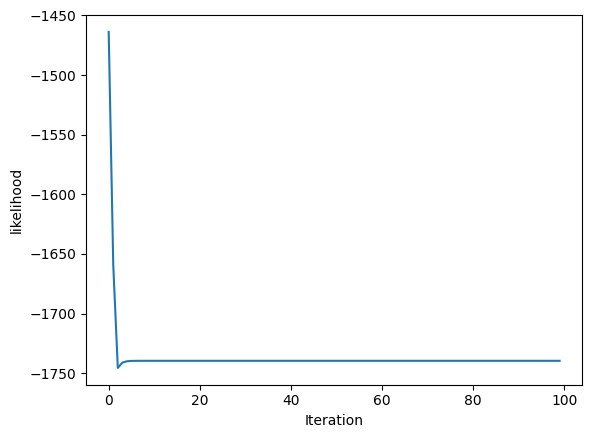

In [8]:
#Lets actually use the developed functions now

#Initialization
epsilons = np.array([0.5, 0.5])  # initial mixing weights
weights = np.array([1, -1])  # initial slopes
biases = np.array([0, 0])   # initial biases
variances = np.array([0.2, 0.1])  # initial variances

#EM Algorithm
max_iterations = 100
tolerance = 1e-6
log_likelihood_array = []
iteration_array = []
for iteration in range(max_iterations):
    respons = e_step(x, y, epsilons, weights, biases, variances)
    new_epsilons, new_weights, new_biases, new_variances = m_step(x, y, respons)
    
    log_like = log_likelihood(x,y,epsilons,weights,biases,variances)
    log_likelihood_array.append(log_like)
    iteration_array.append(iteration)
    epsilons, weights, biases, variances = new_epsilons, new_weights, new_biases, new_variances

print("Converged after {} iterations".format(iteration+1))
print("Mixing weights:", epsilons)
print("Slopes:", weights)
print("Biases:", biases)
print("Variances:", variances)

plt.figure()
plt.plot(iteration_array,log_likelihood_array)
plt.xlabel('Iteration')
plt.ylabel('likelihood')
